Neural network for ionosphere structure detection.

# Theory

## Feedforward

For multilayer perceptron model:

$ X $ - input matrix, where each example is a row and each attribute is a column (attribute $j$ of the example $i$ is $X_{ij}$)

$ H^1 $ - output of the (1st) hidden layer, each example is a row and output of each hidden unit is a column

$ W^0 $ - weights of the 0th layer (input-hidden), where $ W^0_{ij} $ is a weight from $i$ th input to $j$ th output

$ w^0_0 $ - bias weights of the 0th layer (input-hidden), where $ (w^0_0)_i $ is a weight from bias unit (+1) to $i$ th hidden unit

$ w^1 $ - weights of the 1st layer (hidden-output), where $w^1_{i}$ is a weight from $i$ th hidden unit to the output unit

$ w^1_0 $ - bias weight of the 1st layer (hidden-output)

$ y_{calc} = H \cdot w^1 $ - array of calculated output for all examples (probability for each label that it belongs to positive)

$ y $ - array of predicted output labels ('g' or 'b')

$ N $ - number of examples

$ m $ - number of attributes

Result of computations for all examples can be expressed as following:

$$
H^1 = \sigma\left( X \cdot W^0 \right)
$$

$$
y = \sigma\left(H^1 \cdot w^1\right)
$$

Result of computations for example $j$ with $m$ attributes each can be expressed as following:

$$
y_j = \sigma \left( H_j \cdot w^1 \right) = \sigma \left( \sum_{i=0}^{m} H^1_{ji} \cdot w^1_i \right) = 
\sigma \left( w^1_0 + \sum_{i=1}^{m} H^1_{ji} \cdot w^1_i \right),\space j=1\dots N
$$

$$
H_{ji} = \sigma \left( X_j \cdot W^0_j \right) = \sigma \left( \sum_{i=0}^{m} X^1_{ji} \cdot w^1_i \right) = 
\sigma \left( w^1_0 + \sum_{i=1}^{m} H^1_{ji} \cdot w^1_i \right),\space j=1\dots N
$$

## Learning

The process of learning for multilayer perceptron happens using backpropagation. For 1-layer neural network (without hidden layers), learning process can be described by delta rule:

$$
\Delta w_{ji} = \alpha (y'_i - y_i) g'(h_j)x_i
$$
where $w_{ji}$ - weight from input layer's unit $i$ to output layer's unit $j$, $y'_i$ - target (real) value, $y_i$ - calculated value, $g'$ - derivative of activation function of output unit, $h_j$ - weighted sum of inputs, $x_i$ - value of $i$th input.

Weights are updated in the following way:
$$
w_{ji}^{(k)} = w_{ji}^{(k-1)} + \Delta w_{ji}
$$
where $k$ is a number of iteration.

For multilayer perceptron with one hidden layer we use backpropagation.

For output layer:
$$
\Delta w_{ji}^l = \alpha (y^{l}_i - y'^{l}_i) g'(h_j^l)y^{l-1}_j
$$

For hidden layer (before output):
$$
\Delta w_{ji}^l = \alpha \cdot \left( \sum_k (y^{l+1}_k - y'^{l+1}_k) g'(h_k^{l+1}) w^{l}_{kj} \right) \cdot g'(h_j)y^{l-1}_j
$$

where $\Delta w_{ji}^l$ - change in weight from $i$th unit in layer $l$ to $j$th unit in layer $(l+1)$, $y'^{l}_i$ - target value of the $i$th unit of $l$th layer, $y^{l}_i$ - calculated value of the $i$th unit of $l$th layer, $g'$ - derivative of activation function, $h_j^l$ - weighted sum of inputs of $j$th unit of $l$th layer.

In the second expression, term in the parenthesis represent propagation of the error to previous layer. If we define $ \delta_j^l$ as backpropagated error of $j$th unit of $l$th layer, it is possible to write generalized version of backpropagation:

$$
\Delta w_{ji}^l = \alpha \cdot \delta_j^{l} \cdot g'(h_j)y^{l-1}_j
$$

where

$$
\delta_j^l = 
\begin{cases}
y^{l}_i - y'^{l}_i & \text{if $l$ is an output layer} \\
\sum_k \delta_j^{l+1} g'(h_k^{l+1}) w^{l+1}_{kj} & \text{if $l$ is a hidden layer}
\end{cases}
$$

If we use Sigmoid function as activation function, then:

$g(x) = \cfrac{1}{1 + e^{-x}}$

$g'(x) = g(x)(1 - g(x))$

and update rule for 2-layer perceptron can be expressed as following:

for the output layer:
\begin{split}
\Delta w_{ji}^l & = \alpha (y^{l}_i - y'^{l}_i) g'(h_j^l)y^{l-1}_j \\
& = \alpha (y^{l}_i - y'^{l}_i) g(h_j^l) (1 - g(h_j^l))y^{l-1}_j \\
& = \alpha (y^{l}_i - y'^{l}_i) y_j^l (1 - y_j^l)y^{l-1}_j
\end{split}

in the same way, for the hidden layer:
\begin{split}
\Delta w_{ji}^l & = \alpha \cdot \left( \sum_k (y^{l+1}_k - y'^{l+1}_k) g'(h_k^{l+1}) w^{l}_{kj} \right) \cdot g'(h_j)y^{l-1}_j \\
& = \alpha \cdot \left( \sum_k (y^{l+1}_k - y'^{l+1}_k) y_k^{l+1} (1-y_k^{l+1}) w^{l}_{kj} \right) \cdot g'(h_j)y^{l-1}_j
\end{split}

These equations will be implemented in the model of 2-layer perceptron.

# Open the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Percent bar
from tqdm import tqdm

from sklearn import linear_model, neural_network, model_selection, metrics

% matplotlib inline

Fix random seed so it would be easier to compare results

In [2]:
np.random.seed(1)

Read the file

In [3]:
df = pd.read_csv("ionosphere.csv", header=None)
df.head(8)

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g
5,1,0,0.02337,-0.00592,-0.09924,-0.11949,-0.00763,-0.11824,0.14706,0.06637,...,-0.01535,-0.03240,0.09223,-0.07859,0.00732,0.00000,0.00000,-0.00039,0.12011,b
6,1,0,0.97588,-0.10602,0.94601,-0.20800,0.92806,-0.28350,0.85996,-0.27342,...,-0.81634,0.13659,-0.82510,0.04606,-0.82395,-0.04262,-0.81318,-0.13832,-0.80975,g
7,0,0,0.00000,0.00000,0.00000,0.00000,1.00000,-1.00000,0.00000,0.00000,...,1.00000,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,b


Separate dataset into X (attributes) and Y (labels)

In [4]:
X = df.loc[:,:33]
X.head(5)

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.20332,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,0.57528,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,1.00000,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,0.03286,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697


In [5]:
Y = df[34]
Y.head(5)

0    g
1    b
2    g
3    b
4    g
Name: 34, dtype: object

Check how much positive and negative examples there are

In [6]:
print("Positive:", np.count_nonzero(Y == 'g'))
print("Negative:", np.count_nonzero(Y == 'b'))

Positive: 225
Negative: 126


Separate dataset into train and test sets

In [7]:
#X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size = 0.2)
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size = 0.2, stratify=Y)

In [8]:
X_train.shape

(280, 34)

In [9]:
X_test.shape

(71, 34)

Check if splitting is stratified

In [10]:
print("Pos/neg overall ratio:\t", np.count_nonzero(Y == 'g') / np.count_nonzero(Y == 'b'))
print("Pos/neg train ratio:\t", np.count_nonzero(Y_train == 'g') / np.count_nonzero(Y_train == 'b'))
print("Pos/neg test ratio:\t", np.count_nonzero(Y_test == 'g') / np.count_nonzero(Y_test == 'b'))

Pos/neg overall ratio:	 1.7857142857142858
Pos/neg train ratio:	 1.7722772277227723
Pos/neg test ratio:	 1.84


# Data overview

Check how some components depend on each other

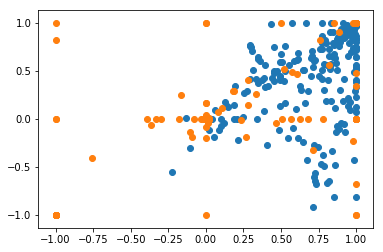

In [11]:
plt.scatter(X[Y == 'g'][6], X[Y == 'g'][32])
plt.scatter(X[Y == 'b'][6], X[Y == 'b'][32])

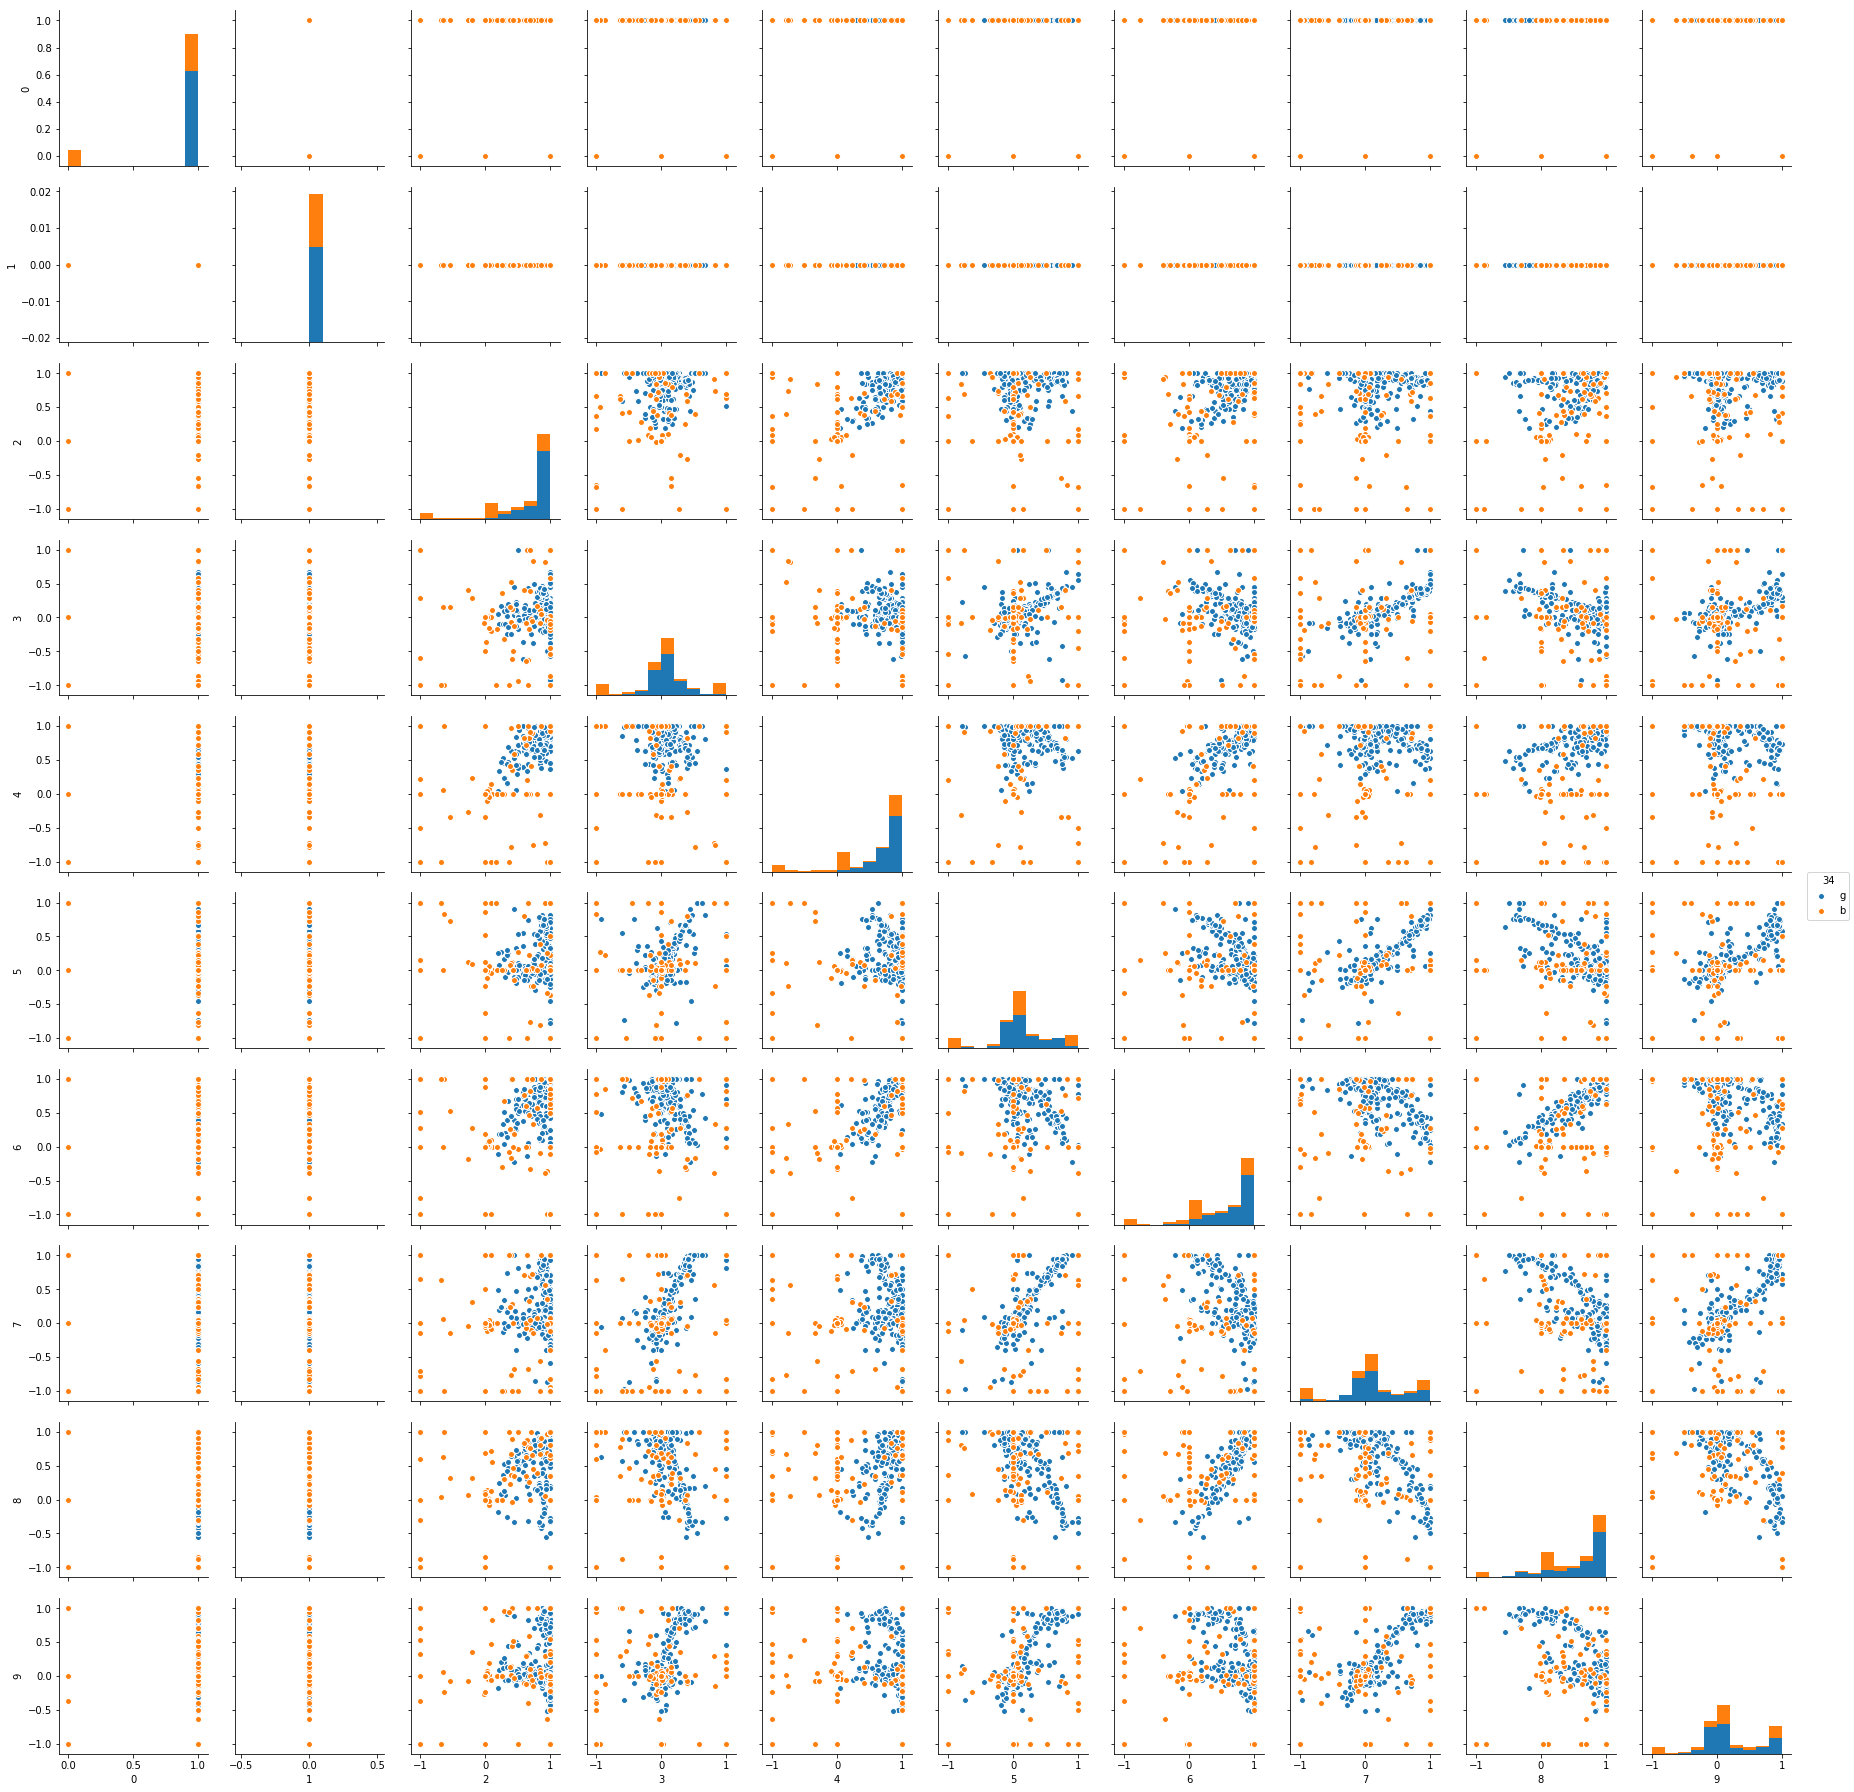

In [12]:
sns.pairplot(df[[i for i in np.arange(0,10)] + [34]], hue = 34)

Look how components 4, 6 and 7 depend on component 5.

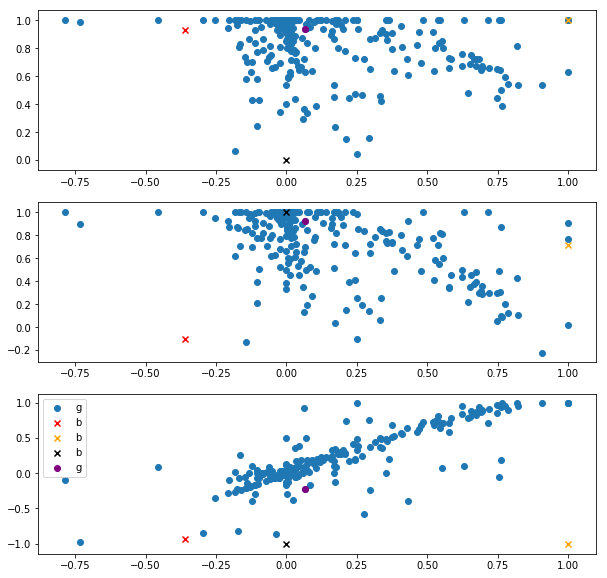

In [13]:
plt.figure(figsize=[10,10])
plt.subplot(311)
plt.scatter(X[Y == 'g'].loc[:,5], X[Y == 'g'].loc[:,4])
plt.scatter(X[Y == 'b'].loc[1,5], X[Y == 'b'].loc[1,4], color='red', marker='x')
plt.scatter(X[Y == 'b'].loc[3,5], X[Y == 'b'].loc[3,4], color='orange', marker='x')
plt.scatter(X[Y == 'b'].loc[7,5], X[Y == 'b'].loc[7,4], color='black', marker='x')
plt.scatter(X[Y == 'g'].loc[4,5], X[Y == 'g'].loc[4,4], color='purple')
plt.subplot(312)
plt.scatter(X[Y == 'g'].loc[:,5], X[Y == 'g'].loc[:,6])
plt.scatter(X[Y == 'b'].loc[1,5], X[Y == 'b'].loc[1,6], color='red', marker='x')
plt.scatter(X[Y == 'b'].loc[3,5], X[Y == 'b'].loc[3,6], color='orange', marker='x')
plt.scatter(X[Y == 'b'].loc[7,5], X[Y == 'b'].loc[7,6], color='black', marker='x')
plt.scatter(X[Y == 'g'].loc[4,5], X[Y == 'g'].loc[4,6], color='purple')
plt.subplot(313)
plt.scatter(X[Y == 'g'].loc[:,5], X[Y == 'g'].loc[:,7])
plt.scatter(X[Y == 'b'].loc[1,5], X[Y == 'b'].loc[1,7], color='red', marker='x')
plt.scatter(X[Y == 'b'].loc[3,5], X[Y == 'b'].loc[3,7], color='orange', marker='x')
plt.scatter(X[Y == 'b'].loc[7,5], X[Y == 'b'].loc[7,7], color='black', marker='x')
plt.scatter(X[Y == 'g'].loc[4,5], X[Y == 'g'].loc[4,7], color='purple')
plt.legend(['g','b','b','b','g'])

# Test on sklearn classifiers (for reference)

**Logistic Regression**

In [14]:
lr = linear_model.LogisticRegression()
lr.fit(X_train, Y_train)
lr.score(X_test, Y_test)

0.8591549295774648

**Neural Network (Multilayer Perceptron)**

In [15]:
pc = neural_network.MLPClassifier(hidden_layer_sizes=30, learning_rate_init=0.1)
pc.fit(X_train, Y_train)
pc.score(X_test, Y_test)

0.9154929577464789

# Implementation

## Single layer model

First, we will try to classify items using Neural Network with 0 hidden layers (or 1-layer neural network).

In [16]:
class single_layer_network():
    """
    One layer perceptron model (0 hidden layers)
    
    Variables in various functions:
      Y_true - real values from the dataset (markers 'g' and 'b')
      Y_num - numerical values of Y_true (values 1 or 0)
      Y_calc - calculated values after applying sigmoid function (between 0 and 1)
      Y_pred - predicted values (markers 'g' and 'b')
    
    Init parameters:
      alpha - learning rate
      max_steps - maximum iterations for gradient descent
    """
    
    # Matrix of weights
    W = None
    # Bias
    w_0 = None
    # Learning rate
    alpha = None
    # Steps limit for backprop learning
    max_steps = None
    # History of cost function
    cost_arr = None
    
    
    def __init__(self, alpha=0.001, max_steps=100):
        """
        Initialize the model with hyperparameters
        """
        self.W = 0
        self.w_0 = 0
        self.alpha = alpha
        self.max_steps = max_steps
        self.cost_arr = np.zeros(max_steps)
    
    
    def _sigmoid(self, x):
        """
        Sigmoid function; in this model - logistic function with image in (0, 1)
        """
        return 1 / (1 + np.exp(x))
    
    
    def _sigmoid_der(self, x):
        """
        Sigmoid derivative
        """
        return np.multiply(self._sigmoid(x), (1 - self._sigmoid(x)))
    
    
    def _cost(self, Y_pred, Y_true):
        """
        Calculate cost function based on predicted and true values of the output before sigmoid applied
        """
        cost_function = 0
        for e in np.arange(len(Y_pred)):
            cost_function += (Y_true[e] - Y_pred[e]) ** 2
        cost_function /= 2 * len(Y_pred)
        return cost_function
    
    
    def _change_weights(self, Y_num, Y_calc, X):
        """
        Correct weights of the NN with respect to gradients of the cost function
        """
        
        # Shuffle elements
        indicies = np.random.permutation(np.arange(len(Y_num)))
        
        # Iterate through each example
        for i in np.arange(len(Y_num)):
            # Shuffled example
            e = indicies[i]
            # Calculate gradient
            dW = Y_num[e] - Y_calc[e]
            # Correct W
            self.W -= np.dot(dW, X[e]) * self._sigmoid_der(np.dot(X[e], self.W)) * self.alpha
            self.w_0 -= dW * self._sigmoid_der(np.dot(X[e], self.W)) * self.alpha
        return
    
    
    def _feed_forward(self, X):
        """
        Calculate output value (including sigmoid)
        """
        Y = self.w_0 + np.dot(X, self.W.T)
        Y = self._sigmoid(Y)
        return Y
    
    
    def _labels_into_numbers(self, Y):
        """
        Transforms labels ('g' and 'b') into numbers (1 and 0)
        """
        Y_num = []
        for i in np.arange(len(Y)):
            if Y[i] == 'g':
                Y_num.append(1)
            else:
                Y_num.append(0)
        Y_num = np.array(Y_num)
        return Y_num
    
    
    def fit(self, X, Y):
        """
        Fit the model to given training examples (arguments X and labels Y)
        """
        
        # Initialize weights as randoms in range (-0.5, 0.5)
        self.W = np.random.rand(X.shape[1]) - 0.5
        self.w_0 = np.random.rand() - 0.5
        
        # Transform char array of labels (g/b) into numerical (1/0)
        Y_num = self._labels_into_numbers(Y)
        
        # Backprop cycle
        for i in tqdm(range(self.max_steps)):
            # Calculate output (numeric value in range 0-1)
            Y_calc = self._feed_forward(X)
            # Calculate cost function
            self.cost_arr[i] = self._cost(Y_calc, Y_num)
            # Backpropagation
            self._change_weights(Y_num, Y_calc, X) # changes self.W
        
        return True
    
    
    def predict(self, X):
        """
        Takes X as an input and, using trained model, calculates outputs
          In:
            X - arguments [#examples, #attributes]
            Y - resulted labels [#examples]
        """
        Y = self._feed_forward(X)
        Y_class = []
        for i in np.arange(len(Y)):
            if Y[i] > 0.5:
                Y_class.append('g')
            else:
                Y_class.append('b')
        return np.array(Y_class)
    
    
    def calc_accuracy(self, X, Y_test):
        Y_pred = self.predict(X)
        score = np.count_nonzero(Y_test == Y_pred) / np.size(Y_test)
        return score
    
    def calc_precision(self, X, Y_test):
        Y_pred = self.predict(X)
        score = np.count_nonzero(Y_test[Y_test == 'g'] == Y_pred[Y_test == 'g']) / np.count_nonzero(Y_pred == 'g')
        return score
    
    def calc_recall(self, X, Y_test):
        Y_pred = self.predict(X)
        score = np.count_nonzero(Y_test[Y_test == 'g'] == Y_pred[Y_test == 'g']) / np.count_nonzero(Y_test == 'g')
        return score
    
    def calc_f1(self, X, Y_test):
        precision = self.calc_precision(X, Y_test)
        recall = self.calc_recall(X, Y_test)
        return 2 * (precision * recall) / (precision + recall)
    
    def calc_scores(self, X, Y_test):
        return {'accuracy': self.calc_accuracy(X, Y_test), 'f1 score': self.calc_f1(X, Y_test)}

Calculate accuracy and f1 score

In [17]:
sln = single_layer_network(alpha=0.001, max_steps=1000)
sln.fit(np.asarray(X_train), np.asarray(Y_train))
sln.calc_scores(np.asarray(X_test), np.asarray(Y_test))

100%|██████████| 1000/1000 [00:14<00:00, 67.00it/s]


{'accuracy': 0.8591549295774648, 'f1 score': 0.9}

Plot cost function over iterations

Text(0,0.5,'Cost')

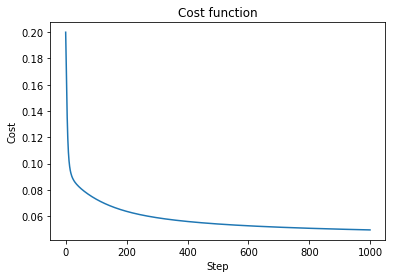

In [18]:
plt.plot(np.arange(sln.cost_arr.shape[0]), sln.cost_arr)
plt.title("Cost function")
plt.xlabel("Step")
plt.ylabel("Cost")

## 2-layer perceptron model

In this Neural Network model, we have 1 hidden layer. Backpropagation is applied in 2 steps (output->hidden and hidden->input).

In [19]:
class neural_net():
    """
    Neural Network model (1 hidden layer)
    
    Class variables:
      W_0 - weights matrix, layers input-hidden
      bias_0 - bias unit weights (+1), layers input-hidden
      w_1 - weights array, layers hidden-output
      bias_1 - bias unit weight (+1), layers hidden-output
      cost_arr - history of cost function through iterations
    
    Init parameters:
      alpha - learning rate
      max_steps - maximum iterations for gradient descent
      hidden_size - amount of units in the hidden layer
      lam - regularization parameter
    
    Variables in various functions:
      Y_true - real values from the dataset (markers 'g' and 'b')
      Y_num - numerical values of Y_true (values 1 or 0)
      Y_calc - calculated values after applying sigmoid function (between 0 and 1)
      Y_pred - predicted values (markers 'g' and 'b')
    """
    
    
    def __init__(self, alpha=0.001, max_steps=100, hidden_size=30, lam=0.1):
        """
        Initialize the model with hyperparameters
        """
        self.W_0 = 0; self.bias_0 = 0
        self.w_1 = 0; self.bias_1 = 0
        self.alpha = alpha
        self.max_steps = max_steps
        self.hidden_size = hidden_size
        self.cost_arr = np.zeros(max_steps)
        self.lam = lam
    
    
    def _sigmoid(self, x):
        """
        Sigmoid function; in this model - logistic function with image in (0, 1)
        """
        return np.divide(1, (1 + np.exp(x)))
    
    
    def _sigmoid_der(self, x):
        """
        Sigmoid derivative
        """
        return np.multiply(self._sigmoid(x), (1 - self._sigmoid(x)))
    
    
    def _cost(self, Y_pred, Y_true):
        """
        Calculate cost function based on predicted and true values of the output before decision applied
        """
        cost_function = 0
        for e in np.arange(len(Y_pred)):
            cost_function += (Y_true[e] - Y_pred[e]) ** 2
        cost_function /= 2 * len(Y_pred)
        return cost_function
    
    
    def _change_weights(self, Y_num, Y_calc, X, inter_1):
        """
        Correct weights of the NN with respect to gradients of the cost function
        """
        
        # Iterate through each example; examples are shuffled
        for e in np.random.permutation(np.arange(len(Y_num))):
            
            # Calculate delta_w for weights hidden-output
            delta_2 = (Y_calc[e] - Y_num[e]) * Y_calc[e] * (1 - Y_calc[e])
            dw_1 = inter_1[e] * delta_2 + self.lam * self.w_1
            dbias_1 = delta_2 + self.lam * self.bias_1
            
            # Calculate delta_w for weights input-hidden
            delta_1 = - np.dot(delta_2, self.w_1) * inter_1[e] * (1 - inter_1[e])
            dW_0 = np.outer(X[e], delta_1) + self.lam * self.W_0
            dbias_0 = delta_2 + self.lam * self.bias_0
            
            # Correct weights
            self.w_1 += dw_1 * self.alpha
            self.bias_1 += dbias_1 * self.alpha
            self.W_0 += dW_0 * self.alpha
            self.bias_0 += dbias_0 * self.alpha
            
        return
    
    
    def _feed_forward(self, X):
        """
        Calculate intermediate values and output value (including sigmoid)
        """
        # Hidden units
        inter_1 = self.bias_0 + np.dot(X, self.W_0)
        inter_1 = self._sigmoid(inter_1)
        # Output unit
        Y = self.bias_1 + np.dot(inter_1, self.w_1.T)
        Y = self._sigmoid(Y)
        return Y, inter_1
    
    
    def _labels_into_numbers(self, Y):
        """
        Transforms labels ('g' and 'b') into numbers (1 and 0)
        """
        Y_num = []
        for i in np.arange(len(Y)):
            if Y[i] == 'g':
                Y_num.append(1)
            else:
                Y_num.append(0)
        Y_num = np.array(Y_num)
        return Y_num
    
    
    def fit(self, X, Y):
        """
        Fit the model to given training examples (arguments X and labels Y)
        """
        
        # Initialize weights as randoms in range (-0.5, 0.5)
        self.bias_0 = np.random.rand(self.hidden_size) - 0.5
        self.W_0 = np.random.rand(X.shape[1], self.hidden_size) - 0.5
        self.bias_1 = np.random.rand() - 0.5
        self.w_1 = np.random.rand(self.hidden_size) - 0.5
        
        # Transform char array of labels (g/b) into numerical (1/0)
        Y_num = self._labels_into_numbers(Y)
        
        # Backprop cycle
        for i in tqdm(range(self.max_steps)):
            # Calculate output value and array of intermediate values (hidden layer)
            # (note that all are numeric values in range 0-1)
            Y_calc, inter_1 = self._feed_forward(X)
            # Calculate cost function
            self.cost_arr[i] = self._cost(Y_calc, Y_num)
            # Backpropagation
            self._change_weights(Y_num, Y_calc, X, inter_1) # changes self.W
        
        return True
    
    
    def predict(self, X):
        """
        Takes X as an input and, using trained model, calculates outputs
          In:
            X - arguments [#examples, #attributes]
            Y - resulted labels [#examples]
        """
        Y, inter_1 = self._feed_forward(X)
        Y_class = []
        for i in np.arange(len(Y)):
            if Y[i] > 0.5:
                Y_class.append('g')
            else:
                Y_class.append('b')
        return np.array(Y_class)
    
    
    def calc_accuracy(self, X, Y_test):
        """
        Calculate accuracy
        """
        Y_pred = self.predict(X)
        score = np.count_nonzero(Y_test == Y_pred) / np.size(Y_test)
        return score
    
    def calc_precision(self, X, Y_test):
        Y_pred = self.predict(X)
        score = np.count_nonzero(Y_test[Y_test == 'g'] == Y_pred[Y_test == 'g']) / np.count_nonzero(Y_pred == 'g')
        return score
    
    def calc_recall(self, X, Y_test):
        Y_pred = self.predict(X)
        score = np.count_nonzero(Y_test[Y_test == 'g'] == Y_pred[Y_test == 'g']) / np.count_nonzero(Y_test == 'g')
        return score
    
    def calc_f1(self, X, Y_test):
        precision = self.calc_precision(X, Y_test)
        recall = self.calc_recall(X, Y_test)
        return 2 * (precision * recall) / (precision + recall)
    
    def calc_scores(self, X, Y_test):
        return {'accuracy': self.calc_accuracy(X, Y_test), 'f1 score': self.calc_f1(X, Y_test)}

Calculate accuracy and f1 score

In [20]:
nn = neural_net(alpha=0.001, max_steps=1000, hidden_size=30, lam=0.005)
nn.fit(np.asarray(X_train), np.asarray(Y_train))
nn.calc_scores(np.asarray(X_test), np.asarray(Y_test))

100%|██████████| 1000/1000 [00:21<00:00, 47.34it/s]


{'accuracy': 0.9436619718309859, 'f1 score': 0.9574468085106383}

Plot cost function over iterations

Text(0,0.5,'Cost')

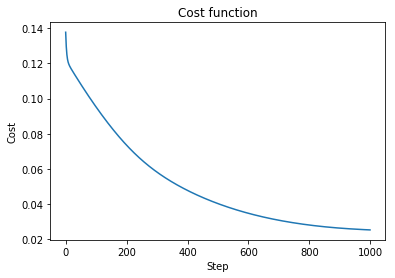

In [21]:
plt.plot(np.arange(nn.cost_arr.shape[0]), nn.cost_arr)
plt.title("Cost function")
plt.xlabel("Step")
plt.ylabel("Cost")

Precision-recall curve

(0.0, 1.0)

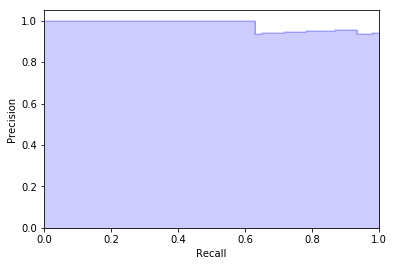

In [22]:
precision, recall, _ = metrics.precision_recall_curve(Y_test, nn._feed_forward(X_test)[0], pos_label='g')
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])